# Create session-specific ROI maps
- First creat a map for each image type
    - First catch multi-matching ROIs with IoU 0.2.
        - Take smaller |0.5-percentile|.
    - Then consider one-to-one overlapping ROIs
        - If IoU < 0.2, leave both.
        - If IoU > 0.8, 
- Then merge from meanImg -> meanImgE -> max_proj
- Test cumulative additional ROIs (not including multi ROIs)
- Test different orders of the image types

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
mice = [25,27,30,36,39,52]
test_sessions = [1,15]
planes = range(1,9)
save_dir = Path(r'C:\Users\shires\Dropbox\Works\Projects\2020 Neural stretching in S1\Analysis\cellpose_mask_test')
base_dir_1 = Path('F:/')
base_dir_2 = Path('D:/')

In [3]:
def get_iou_ioa_mat(mask_3d1, mask_3d2):
    # mask_3d are ordered to have 1 to n ids
    assert len(mask_3d1.shape) == len(mask_3d2.shape) == 3
    assert mask_3d1.max() == mask_3d1.shape[2]
    assert mask_3d2.max() == mask_3d2.shape[2]

    iou_mat = np.zeros((mask_3d1.shape[2], mask_3d2.shape[2]))
    ioa_mat1 = np.zeros((mask_3d1.shape[2], mask_3d2.shape[2]))
    ioa_mat2 = np.zeros((mask_3d1.shape[2], mask_3d2.shape[2]))

    # going from mask1 to mask2
    # Collect all the roi_inds2 that are visited by roi_inds1
    visited_roi_inds2 = []
    for j in range(mask_3d1.shape[2]):
        temp_roi_ind1_map = np.sum(mask_3d1 == j + 1, axis=2)
        y, x = np.where(temp_roi_ind1_map > 0)
        
        temp_roi_ind2_visit = np.setdiff1d(np.unique(mask_3d2[y, x, :]), [0])
        visited_roi_inds2.extend(temp_roi_ind2_visit)
        for temp_roi_2 in temp_roi_ind2_visit:
            k = temp_roi_2 - 1
            temp_roi_ind2_map = np.sum(mask_3d2 == temp_roi_2, axis=2)
            intersection_map = temp_roi_ind1_map * temp_roi_ind2_map > 0
            union_map = temp_roi_ind1_map + temp_roi_ind2_map > 0
            iou_mat[j, k] = np.sum(intersection_map) / np.sum(union_map)
            ioa_mat1[j, k] = np.sum(intersection_map) / np.sum(temp_roi_ind1_map)
            ioa_mat2[j, k] = np.sum(intersection_map) / np.sum(temp_roi_ind2_map)
    # going from mask2 to mask1
    # Collect all the roi_inds1 that are not visited by roi_inds2 in the previous step
    left_roi_inds2 = np.setdiff1d(np.arange(1,mask_3d2.shape[2]), np.unique(visited_roi_inds2))
    for temp_roi_ind2 in left_roi_inds2:
        k = temp_roi_ind2 - 1
        temp_roi_ind2_map = np.sum(mask_3d2 == temp_roi_ind2, axis=2)
        y, x = np.where(temp_roi_ind2_map > 0)
        temp_roi_ind1_visit = np.setdiff1d(np.unique(mask_3d1[y, x, :]), [0])
        for temp_roi_ind1 in temp_roi_ind1_visit:
            j = temp_roi_ind1 - 1
            temp_roi_ind1_map = np.sum(mask_3d1 == temp_roi_ind1, axis=2)
            intersection_map = temp_roi_ind2_map * temp_roi_ind1_map > 0
            union_map = temp_roi_ind2_map + temp_roi_ind1_map > 0
            iou_mat[j, k] = np.sum(intersection_map) / np.sum(union_map)
            ioa_mat1[j, k] = np.sum(intersection_map) / np.sum(temp_roi_ind1_map)
            ioa_mat2[j, k] = np.sum(intersection_map) / np.sum(temp_roi_ind2_map)
    return iou_mat, ioa_mat1, ioa_mat2

def deal_with_multi_overlap(ioa_mat1, ioa_mat2, mask_3d1, mask_3d2, ioa_threshold=0.5):
    assert len(mask_3d1.shape) == len(mask_3d2.shape) == 3
    assert mask_3d1.max() == mask_3d1.shape[2]
    assert mask_3d2.max() == mask_3d2.shape[2]
    # Only care about multi-to-one, since that was the only cases that I've seen
    # when there are multiple rois from mask2 that overlap with one roi from mask1
    multi_ind1 = np.where(np.sum(ioa_mat2 >= ioa_threshold, axis=1)>1)[0]
    # when there are multiple rois from mask1 that overlap with one roi from mask2
    multi_ind2 = np.where(np.sum(ioa_mat1 >= ioa_threshold, axis=0)>1)[0]
    # These two are assumed to be disjoint, because there was no multi-to-multi case

    area_dist1 = np.array([np.sum(mask_3d1==id) for id in range(1, mask_3d1.max()+1)])
    area_dist2 = np.array([np.sum(mask_3d2==id) for id in range(1, mask_3d2.max()+1)])
    area_dist = np.concatenate([area_dist1, area_dist2])

    ind_remove_from_mask1 = []
    ind_remove_from_mask2 = []

    for ind in multi_ind1:
        temp_overlap_roi_inds2 = np.where(ioa_mat2[ind,:] >= ioa_threshold)[0]
        # pick the one(s) with closer to median area
        percentile_to_med1 = np.abs(0.5 - np.sum(area_dist < area_dist1[ind])/len(area_dist))
        percentile_to_med2 = [np.abs(0.5 - np.sum(area_dist < area_dist2[i])/len(area_dist)) for i in temp_overlap_roi_inds2]
        if (percentile_to_med2 > percentile_to_med1).any():
            for temp_ind in temp_overlap_roi_inds2:
                ind_remove_from_mask2.append(temp_ind)
        else:
            ind_remove_from_mask1.append(ind)

    # repeat for multi_ind2
    for ind in multi_ind2:
        temp_overlap_roi_inds1 = np.where(ioa_mat1[:,ind] >= ioa_threshold)[0]
        # pick the one(s) with closer to median area
        percentile_to_med2 = np.abs(0.5 - np.sum(area_dist < area_dist2[ind])/len(area_dist))
        percentile_to_med1 = [np.abs(0.5 - np.sum(area_dist < area_dist1[i])/len(area_dist)) for i in temp_overlap_roi_inds1]
        if (percentile_to_med1 > percentile_to_med2).any():
            for temp_ind in temp_overlap_roi_inds1:
                ind_remove_from_mask1.append(temp_ind)
        else:
            ind_remove_from_mask2.append(ind)
    for ind in ind_remove_from_mask1:
        ioa_mat1[ind,:] = 0
        ioa_mat2[ind,:] = 0
    for ind in ind_remove_from_mask2:
        ioa_mat1[:,ind] = 0
        ioa_mat2[:,ind] = 0
    return ind_remove_from_mask1, ind_remove_from_mask2, ioa_mat1, ioa_mat2


def deal_with_one_to_one(ioa_mat1, ioa_mat2, mask_3d1, mask_3d2,
                        ind_remove_from_mask1, ind_remove_from_mask2,
                        ioa_threshold=0.5):
    ###
    # After multi_overlap is dealt with
    ###
    assert len(mask_3d1.shape) == len(mask_3d2.shape) == 3
    assert mask_3d1.max() == mask_3d1.shape[2]
    assert mask_3d2.max() == mask_3d2.shape[2]
    # Sweeping through one direction is enough, because only one-to-one match (if any) is left
    area_dist1 = np.array([np.sum(mask_3d1==id) for id in range(1, mask_3d1.max()+1)])
    area_dist2 = np.array([np.sum(mask_3d2==id) for id in range(1, mask_3d2.max()+1)])
    area_dist = np.concatenate([area_dist1, area_dist2])
    for ind1 in range(ioa_mat1.shape[0]):
        if (ioa_mat1[ind1,:] >= ioa_threshold).any() or (ioa_mat2[ind1,:] >= ioa_threshold).any():
            match_ind2 = np.concatenate([np.where(ioa_mat1[ind1,:] >= ioa_threshold)[0],
                                         np.where(ioa_mat2[ind1,:] >= ioa_threshold)[0]])
            match_ind2 = np.unique(match_ind2)
            percentile_to_med1 = np.abs(0.5 - np.sum(area_dist < area_dist1[ind1])/len(area_dist))
            percentile_to_med2 = np.abs(0.5 - np.sum(area_dist < area_dist2[match_ind2])/len(area_dist))
            if percentile_to_med1 < percentile_to_med2:
                ind_remove_from_mask2.append(match_ind2)
            else:
                ind_remove_from_mask1.append(ind1)
    return ind_remove_from_mask1, ind_remove_from_mask2


def clean_and_merge_masks(mask_3d1, mask_3d2, ind_remove_from_mask1, ind_remove_from_mask2):
    assert len(mask_3d1.shape) == len(mask_3d2.shape) == 3
    assert mask_3d1.max() == mask_3d1.shape[2]
    assert mask_3d2.max() == mask_3d2.shape[2]
    # just to be sure (ids1 = range(1, mask_3d1.max()+1)
    ids1 = np.setdiff1d(np.unique(mask_3d1), 0)
    ids2 = np.setdiff1d(np.unique(mask_3d2), 0)
    for ind1 in ind_remove_from_mask1:
        mask_3d1[mask_3d1==ids1[ind1]] = 0
    for ind2 in ind_remove_from_mask2:
        mask_3d2[mask_3d2==ids2[ind2]] = 0
    mask_3d1, _ = reorder_mask(mask_3d1)
    mask_3d2, _ = reorder_mask(mask_3d2, startswith=mask_3d1.max()+1)
    mask_3d_merged = np.dstack([mask_3d1, mask_3d2])
    return mask_3d_merged


def reorder_mask(mask_3d, startswith=1):
    # Reorder maks ids to be 1 to n
    ids = np.setdiff1d(np.unique(mask_3d), 0)
    new_mask = np.zeros((*mask_3d.shape[:2], len(ids)), dtype=np.uint16)
    for i, id in enumerate(ids):
        y, x = np.where(mask_3d == id)[:2]
        new_mask[y, x, i] = i + startswith
    new_ids = np.setdiff1d(np.unique(new_mask), 0)
    return new_mask, new_ids


def make_3d_mask(mask_2d):
    """Make 3D mask from 2D mask.
    Also reorder mask ids to be 1 to n
    """
    ids = np.setdiff1d(np.unique(mask_2d), 0)
    mask_3d = np.zeros((mask_2d.shape[0], mask_2d.shape[1], len(ids)), dtype=np.uint16)
    for i, id_ in enumerate(ids):
        y,x = np.where(mask_2d == id_)
        mask_3d[y, x, i] = i+1
    return mask_3d


def collate_masks(mask_3d1, mask_3d2, iou_threshold=0.3):
    """Collate two masks into one.
    Also reorder mask ids to be 1 to n.
    Plus, calculate unique ROIs going forward and backward (from mask_3d1 to mask_3d2 and vice versa)
    using IoU threshold
    """
    assert len(mask_3d1.shape) == len(mask_3d2.shape) == 3
    assert mask_3d1.max() == mask_3d1.shape[2]
    assert mask_3d2.max() == mask_3d2.shape[2]
    iou_mat, ioa_mat1, ioa_mat2 = get_iou_ioa_mat(mask_3d1, mask_3d2)

    num_unique_in_mask1 = len(np.where(np.sum(iou_mat >= iou_threshold, axis=1) == 0)[0])
    num_unique_in_mask2 = len(np.where(np.sum(iou_mat >= iou_threshold, axis=0) == 0)[0])

    ind_remove_from_mask1, ind_remove_from_mask2, \
        ioa_mat1, ioa_mat2 = deal_with_multi_overlap(ioa_mat1, ioa_mat2,
                                                    mask_3d1, mask_3d2)
    ind_remove_from_mask1, ind_remove_from_mask2 \
        = deal_with_one_to_one(ioa_mat1, ioa_mat2, mask_3d1, mask_3d2,
                               ind_remove_from_mask1, ind_remove_from_mask2)
    new_mask = clean_and_merge_masks(mask_3d1, mask_3d2, 
                                     ind_remove_from_mask1,
                                     ind_remove_from_mask2)
    return new_mask, (num_unique_in_mask1, num_unique_in_mask2)


In [44]:
mouse = mice[0]
if mouse < 31:
    base_dir = base_dir_1
else:
    base_dir = base_dir_2

session = test_sessions[0]
plane = planes[4]

# print(f'mouse {mouse}, session {session}, plane {plane}')
ops_fn = base_dir / f'{mouse:03}' / f'plane_{plane}' / f'{session:03}' / 'plane0' / 'ops.npy'
ops = np.load(ops_fn, allow_pickle=True).item()

results = np.load(save_dir / f'masks_{mouse:03d}_{session:03d}_{plane:03d}.npy', allow_pickle=True)

image_type_i = 1
mask = results[image_type_i]
if image_type_i == 0:
    img = ops['meanImg']
elif image_type_i == 1:
    img = ops['meanImgE']
else:
    img = ops['max_proj']
    
# i = 0
# mask_3d1 = make_3d_mask(mask[i])
# mask_3d2 = make_3d_mask(mask[i+1])
# iou_mat, ioa_mat1, ioa_mat2 = get_iou_ioa_mat(mask_3d1, mask_3d2)
# ind_remove_from_mask1, ind_remove_from_mask2, \
#     ioa_mat1, ioa_mat2 = deal_with_multi_overlap(ioa_mat1, ioa_mat2,
#                                                  mask_3d1, mask_3d2)
# ind_remove_from_mask1, ind_remove_from_mask2 = deal_with_one_to_one(ioa_mat1, ioa_mat2, mask_3d1, mask_3d2,
#                         ind_remove_from_mask1, ind_remove_from_mask2)
# new_mask = clean_and_merge_masks(mask_3d1, mask_3d2, ind_remove_from_mask1, ind_remove_from_mask2)


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


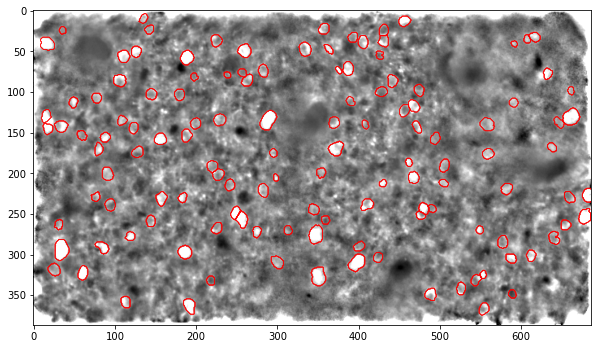

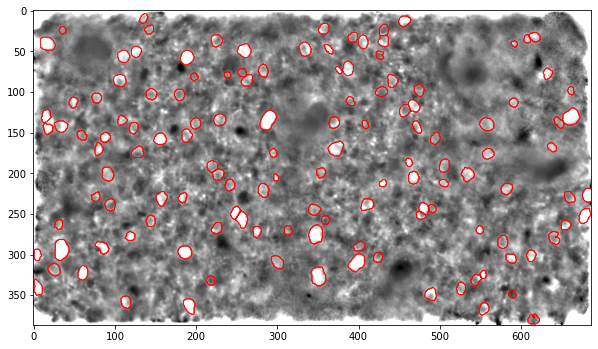

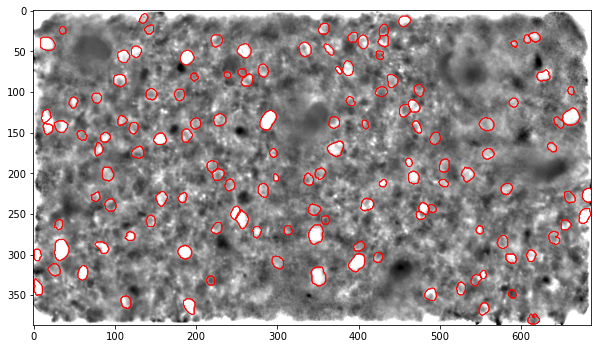

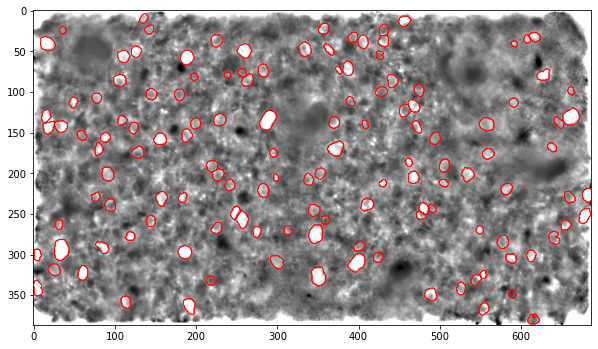

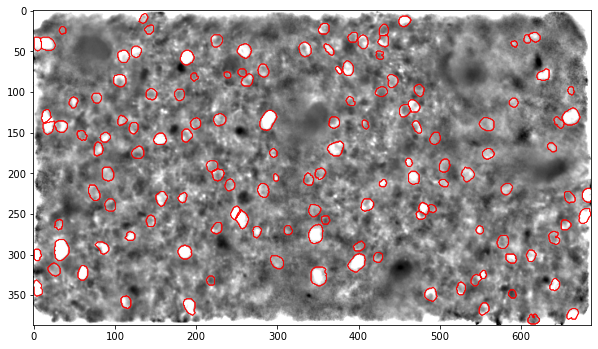

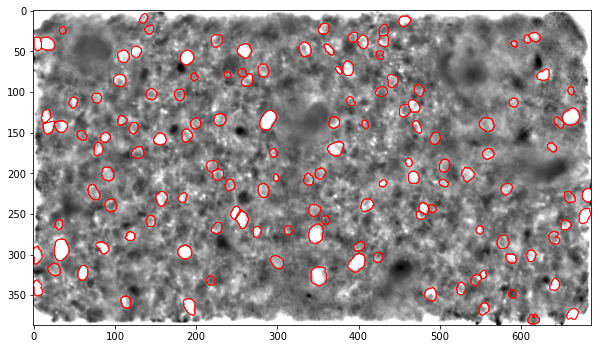

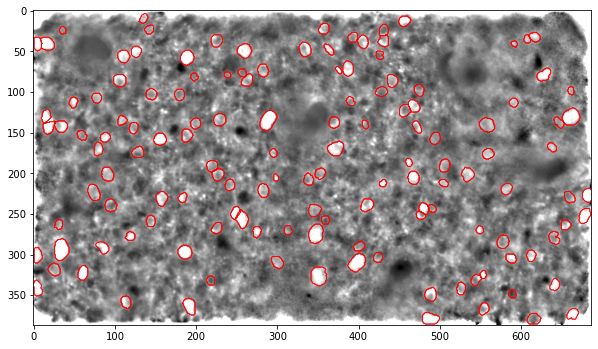

In [45]:
for i in range(len(mask)-1):
    if i == 0:
        new_mask = make_3d_mask(mask[i])
    next_mask = make_3d_mask(mask[i+1])
    new_mask = collate_masks(new_mask, next_mask)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.imshow(img, cmap='gray')
    for j in range(new_mask.shape[2]):
        ax.contour(new_mask[:,:,j], colors='r', linewidths=0.3)

C:\Users\shires\AppData\Local\Temp/ipykernel_29240/1187070368.py:125: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mask_3d1[mask_3d1==ids1[ind1]] = 0
C:\Users\shires\AppData\Local\Temp/ipykernel_29240/1187070368.py:127: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mask_3d2[mask_3d2==ids2[ind2]] = 0


KeyboardInterrupt: 

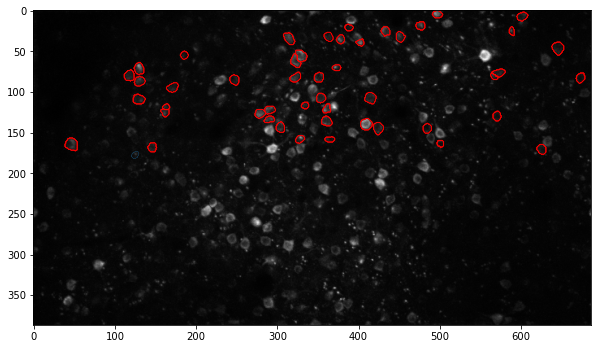

In [85]:
fig_save_dir = save_dir / 'merged_masks'
fig_save_dir.mkdir(exist_ok=True)

num_rois_all = []
num_unique_rois_all = []                   
for mouse in mice:
    if mouse < 31:
        base_dir = base_dir_1
    else:
        base_dir = base_dir_2
    num_rois_mouse = []
    num_unique_rois_mouse = []
    for session in test_sessions:
        num_rois_session = []
        num_unique_rois_session = []
        for plane in planes:
            # print(f'mouse {mouse}, session {session}, plane {plane}')
            ops_fn = base_dir / f'{mouse:03}' / f'plane_{plane}' / f'{session:03}' / 'plane0' / 'ops.npy'
            ops = np.load(ops_fn, allow_pickle=True).item()

            results = np.load(save_dir / f'masks_{mouse:03d}_{session:03d}_{plane:03d}.npy', allow_pickle=True)
            
            num_rois_plane = []
            num_unique_rois_plane = []
            for image_type_i in range(3):
                mask = results[image_type_i]
                if image_type_i == 0:
                    img = ops['meanImg']
                elif image_type_i == 1:
                    img = ops['meanImgE']
                else:
                    img = ops['max_proj']

                num_rois = []
                num_unique_rois = []
                for i in range(len(mask)-1):
                    if i == 0:
                        new_mask = make_3d_mask(mask[i])
                        fig, ax = plt.subplots(figsize=(10,6))
                        ax.imshow(img, cmap='gray')
                        for j in range(new_mask.shape[2]):
                            ax.contour(new_mask[:,:,j], colors='r', linewidths=0.3)
                        fig_savefn = f'{fig_save_dir}/mouse{mouse:03d}_session{session:03d}_plane{plane}_image{image_type_i}_mask{i}.png'
                        fig.savefig(fig_savefn, bbox_inches='tight')
                        plt.close(fig)
                        num_rois.append(new_mask.shape[2])
                    next_mask = make_3d_mask(mask[i+1])
                    new_mask, unique_roi_num = collate_masks(new_mask, next_mask)
                    num_rois.append(new_mask.shape[2])
                    num_unique_rois.append(unique_roi_num)
                    fig, ax = plt.subplots(figsize=(10,6))
                    ax.imshow(img, cmap='gray')
                    for j in range(new_mask.shape[2]):
                        ax.contour(new_mask[:,:,j], colors='r', linewidths=0.3)
                    fig_savefn = f'{fig_save_dir}/mouse{mouse:03d}_session{session:03d}_plane{plane}_image{image_type_i}_mask{i+1}.png'
                    fig.savefig(fig_savefn, bbox_inches='tight')
                    plt.close(fig)
                num_rois_plane.append(num_rois)
                num_unique_rois_plane.append(num_unique_rois)
            num_rois_session.append(num_rois_plane)
            num_unique_rois_session.append(num_unique_rois_plane)
        num_rois_mouse.append(num_rois_session)
        num_unique_rois_mouse.append(num_unique_rois_session)
    num_rois_all.append(num_rois_mouse)
    num_unique_rois_all.append(num_unique_rois_mouse)

np.save(fig_save_dir / 'num_rois.npy', num_rois_all)
np.save(fig_save_dir / 'num_unique_rois.npy', num_unique_rois_all)
                    


In [ ]:
np.save(fig_save_dir / 'num_rois_test01.npy', num_rois_all)
np.save(fig_save_dir / 'num_unique_rois_test01.npy', num_unique_rois_all)

## test run up until JK036 session 001 plane 3
- There were some error cases (quite many) where multi overlap was not removed well.
    - Curated some examples in the pptx. Take a look at them
- It takes really long (1 hr for a plane)
    - 8 planes * 25 sessions * 6 mice = 1200 (hr) ~ 5 days with 20 core (~2 days with 64 core)
    - This is AFTER cellpose. Cellpose running itself takes quite a lot of time.
    - See if meanImgE covers most of the ROIs from meanImg (can reduce compute time by the factor of 2)
    - See if diameter increment in 2 rather than 1 results in similar ROI extraction quality (another factor of 2)


In [50]:
mouse = 30
session = 1
plane = 5
image_type_i = 2
    
if mouse < 31:
    base_dir = base_dir_1
else:
    base_dir = base_dir_2
ops_fn = base_dir / f'{mouse:03}' / f'plane_{plane}' / f'{session:03}' / 'plane0' / 'ops.npy'
ops = np.load(ops_fn, allow_pickle=True).item()

results = np.load(save_dir / f'masks_{mouse:03d}_{session:03d}_{plane:03d}.npy', allow_pickle=True)

mask = results[image_type_i]
if image_type_i == 0:
    img = ops['meanImg']
elif image_type_i == 1:
    img = ops['meanImgE']
else:
    img = ops['max_proj']

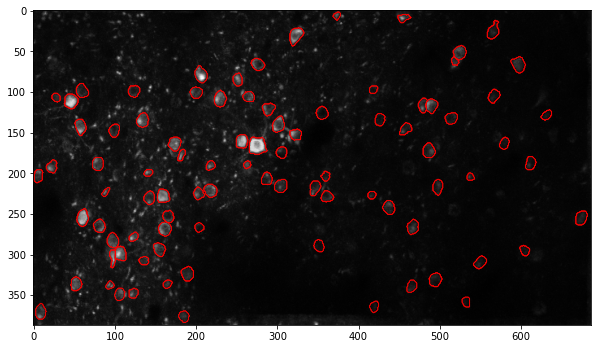

In [4]:
i = 0
new_mask = make_3d_mask(mask[i])
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(img, cmap='gray')
for j in range(new_mask.shape[2]):
    ax.contour(new_mask[:,:,j], colors='r', linewidths=0.3)

In [20]:
i += 1
new_mask = merged_mask.copy()

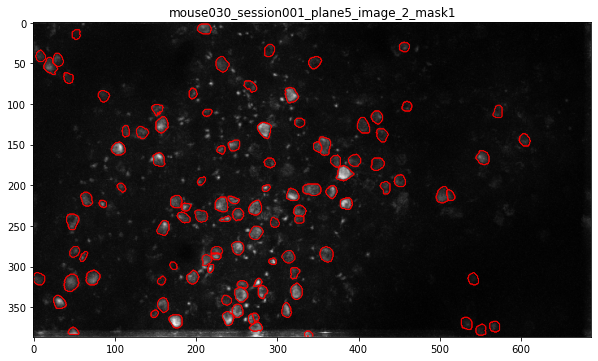

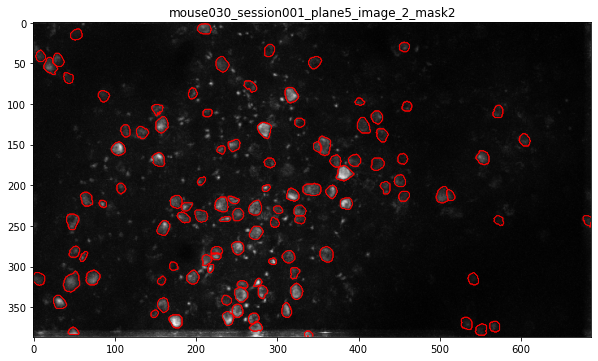

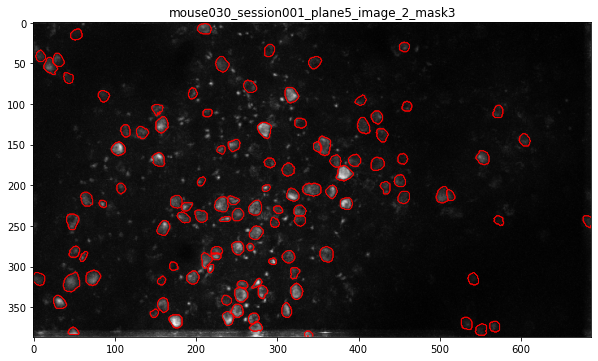

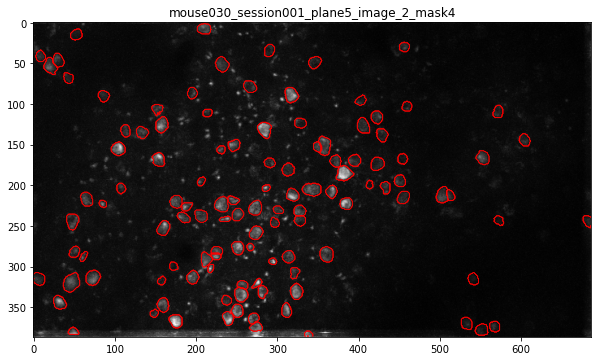

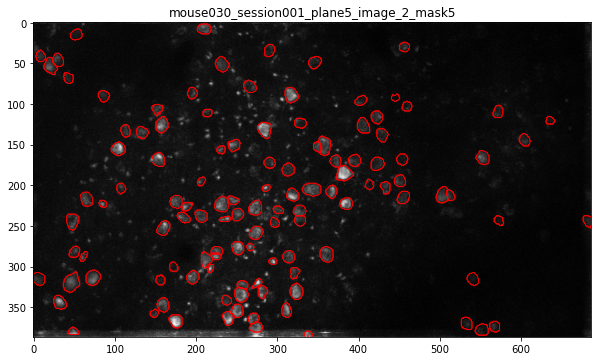

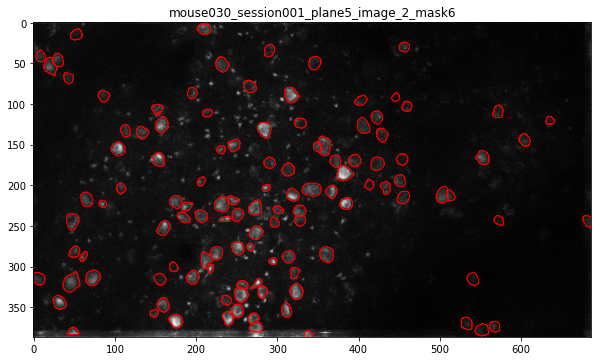

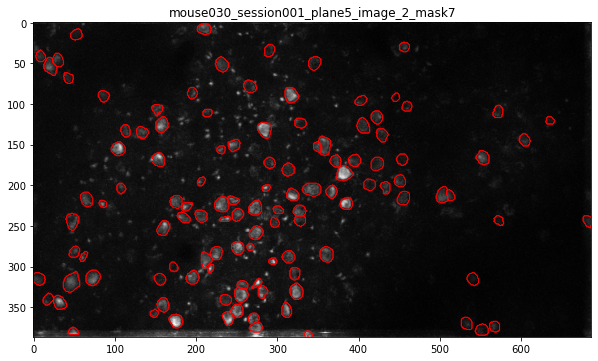

In [51]:
for i in range(len(mask)-1):
    if i == 0:
        new_mask = make_3d_mask(mask[i])
    else:
        new_mask = merged_mask
    next_mask = make_3d_mask(mask[i+1])
    iou_mat, ioa_mat1, ioa_mat2 = get_iou_ioa_mat(new_mask, next_mask)
    ind_remove_from_mask1, ind_remove_from_mask2, \
            ioa_mat1, ioa_mat2 = deal_with_multi_overlap(ioa_mat1, ioa_mat2,
                                                        new_mask, next_mask)
    ind_remove_from_mask1_final, ind_remove_from_mask2_final \
            = deal_with_one_to_one(ioa_mat1, ioa_mat2, new_mask, next_mask,
                                ind_remove_from_mask1, ind_remove_from_mask2)
    merged_mask = clean_and_merge_masks(new_mask, next_mask, 
                                        ind_remove_from_mask1_final,
                                        ind_remove_from_mask2_final)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.imshow(img, cmap='gray')
    for j in range(merged_mask.shape[2]):
        ax.contour(merged_mask[:,:,j], colors='r', linewidths=0.3)
    ax.set_title(f'mouse{mouse:03d}_session{session:03d}_plane{plane}_image_{image_type_i}_mask{i+1}')

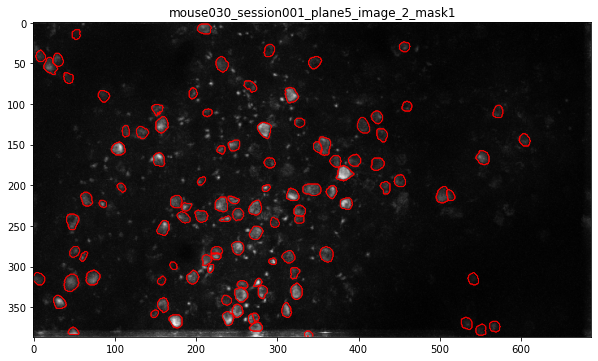

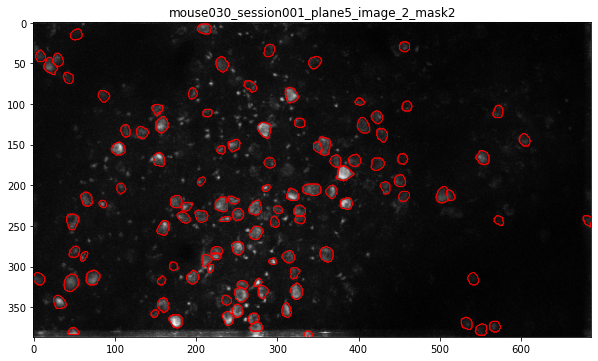

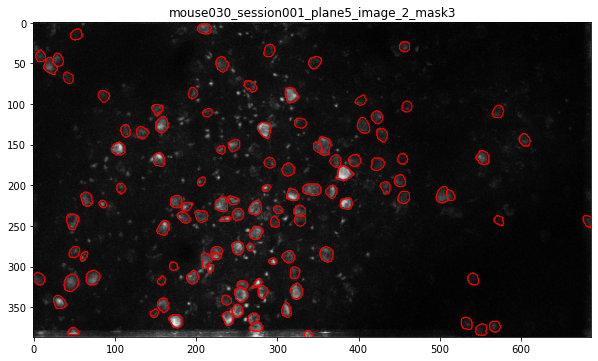

In [57]:
for i in range(3):
    if i == 0:
        new_mask = make_3d_mask(mask[i])
    else:
        new_mask = merged_mask
    next_mask = make_3d_mask(mask[i+1])
    iou_mat, ioa_mat1, ioa_mat2 = get_iou_ioa_mat(new_mask, next_mask)
    ind_remove_from_mask1, ind_remove_from_mask2, \
            ioa_mat1, ioa_mat2 = deal_with_multi_overlap(ioa_mat1, ioa_mat2,
                                                        new_mask, next_mask)
    ind_remove_from_mask1_final, ind_remove_from_mask2_final \
            = deal_with_one_to_one(ioa_mat1, ioa_mat2, new_mask, next_mask,
                                ind_remove_from_mask1, ind_remove_from_mask2)
    merged_mask = clean_and_merge_masks(new_mask, next_mask, 
                                        ind_remove_from_mask1_final,
                                        ind_remove_from_mask2_final)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.imshow(img, cmap='gray')
    for j in range(merged_mask.shape[2]):
        ax.contour(merged_mask[:,:,j], colors='r', linewidths=0.3)
    ax.set_title(f'mouse{mouse:03d}_session{session:03d}_plane{plane}_image_{image_type_i}_mask{i+1}')

# Some more modifications
- Moved data to the RAID and NAS
    - Now parallel processing can be run in both 20 and 64-core workstations.
- Too small ROIs (looks like dendrite) - increase diameter threshold for dendrites
- Results from meanImgE seem to include those from meanImg
    - Test it

In [4]:
base_dir = Path(r'E:\TPM\JK\h5')
save_dir = base_dir

In [88]:
session_tuples = []
for mouse in mice:
    for plane in planes:
        plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
        sessions = [x.name for x in plane_dir.iterdir() if x.is_dir() and x.name[0].isdigit() and x.name[-1].isdigit()]
        # list of (mouse,plane,session) tuples
        test_sessions = [(mouse, plane, session) for session in sessions]
        session_tuples.extend(test_sessions)
len(session_tuples)

1472

In [27]:
si = 886
session_tuple = session_tuples[si]
print(session_tuple)

(36, 8, '004')


In [42]:
mouse = session_tuple[0]
plane = session_tuple[1]
session = session_tuple[2]
session_dir = base_dir / f'{mouse:03}/plane_{plane}' / session / 'plane0'
cp_masks = np.load(session_dir / f'{mouse:03}_plane_{plane}_{session}_cp_masks.npy', allow_pickle=True).item()
print(cp_masks.keys())

dict_keys(['mean_mask_list', 'meanE_mask_list', 'max_mask_list'])


In [45]:
keys = cp_masks.keys()
merged_mask_list = []
for key in keys:
    masks = cp_masks[key]
    for i in range(len(masks)-1):
        print (f'{key}, {i}')
        if i == 0:
            new_mask = make_3d_mask(masks[i])
        else:
            new_mask = merged_mask
        next_mask = make_3d_mask(masks[i+1])
        iou_mat, ioa_mat1, ioa_mat2 = get_iou_ioa_mat(new_mask, next_mask)
        ind_remove_from_mask1, ind_remove_from_mask2, \
                ioa_mat1, ioa_mat2 = deal_with_multi_overlap(ioa_mat1, ioa_mat2,
                                                            new_mask, next_mask)
        ind_remove_from_mask1_final, ind_remove_from_mask2_final \
                = deal_with_one_to_one(ioa_mat1, ioa_mat2, new_mask, next_mask,
                                    ind_remove_from_mask1, ind_remove_from_mask2)
        merged_mask = clean_and_merge_masks(new_mask, next_mask, 
                                            ind_remove_from_mask1_final,
                                            ind_remove_from_mask2_final)
    merged_mask_list.append(merged_mask)

mean_mask_list, 0
mean_mask_list, 1
mean_mask_list, 2
mean_mask_list, 3
mean_mask_list, 4
mean_mask_list, 5
mean_mask_list, 6
meanE_mask_list, 0
meanE_mask_list, 1
meanE_mask_list, 2
meanE_mask_list, 3
meanE_mask_list, 4
meanE_mask_list, 5
meanE_mask_list, 6
max_mask_list, 0
max_mask_list, 1
max_mask_list, 2
max_mask_list, 3
max_mask_list, 4
max_mask_list, 5
max_mask_list, 6


In [72]:
iou_mat, ioa_mat1, ioa_mat2 = get_iou_ioa_mat(merged_mask_list[0], merged_mask_list[1])

In [74]:
iou_threshold=0.3
num_unique_in_mask1 = len(np.where(np.sum(iou_mat >= iou_threshold, axis=1) == 0)[0])
num_unique_in_mask2 = len(np.where(np.sum(iou_mat >= iou_threshold, axis=0) == 0)[0])
print(num_unique_in_mask1)
print(num_unique_in_mask2)

5
65


# Run in parallel
- Seems the results from mean have some unique ROIs over those from meanE
- Consider applying dendrite filtering either before or after
    - Check the final ROI map first
- 230820_roi_merging_test_parallel.py
- 230910_cp_masks_parallel.py

In [ ]:
# Check which one failed
